In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from PIL import Image
import os
import zipfile
import logging
import json


from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import alibi_detect.ad as adv
from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score


Using TensorFlow backend.
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

In [3]:
from sklearn.metrics import confusion_matrix
%set_env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


# Load mnist

In [8]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


# Model

In [9]:
import os
import tensorflow

In [13]:

def model_mnist(typ = "keras"):
    if typ == 'tf_keras':
        
        tf.keras.backend.clear_session()
        logger = tf.get_logger()
        logger.setLevel(logging.ERROR)
        
        inputs = tensorflow.keras.layers.Input(shape=(X_train.shape[1:]))
        x = tensorflow.keras.layers.Conv2D(64, 2, padding='same', activation='relu')(inputs)
        x = tensorflow.keras.layers.MaxPooling2D(pool_size=2)(x)
        x = tensorflow.keras.layers.Dropout(.3)(x)
    
        x = tensorflow.keras.layers.Conv2D(32, 2, padding='same', activation='relu')(x)
        x = tensorflow.keras.layers.MaxPooling2D(pool_size=2)(x)
        x = tensorflow.keras.layers.Dropout(.3)(x)
    
        x = tensorflow.keras.layers.Flatten()(x)
        x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
        x = tensorflow.keras.layers.Dropout(.5)(x)
        logits = tensorflow.keras.layers.Dense(10, name='logits')(x)
        outputs = tensorflow.keras.layers.Activation('softmax', name='softmax')(logits)
        model = tensorflow.keras.models.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    elif typ == 'keras':
        inputs = keras.layers.Input(shape=(X_train.shape[1:]))
        x = keras.layers.Conv2D(64, 2, padding='same', activation='relu')(inputs)
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
        x = keras.layers.Dropout(.3)(x)
    
        x = keras.layers.Conv2D(32, 2, padding='same', activation='relu')(x)
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
        x = keras.layers.Dropout(.3)(x)
    
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dropout(.5)(x)
        logits = keras.layers.Dense(10, name='logits')(x)
        outputs = keras.layers.Activation('softmax', name='softmax')(logits)
        model = keras.models.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
 

In [15]:
model = model_mnist(typ='tf_keras')
model.fit(X_train,
              y_train,
              epochs=2,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 2s 39us/sample - loss: 0.5022 - accuracy: 0.8400 - val_loss: 0.1274 - val_accuracy: 0.9635
Epoch 2/2
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1687 - accuracy: 0.9479 - val_loss: 0.0698 - val_accuracy: 0.9782


In [16]:
model_json = model.to_json()
with open("model_tmp/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_tmp/model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
json_file = open('model_tmp/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [17]:
loaded_model = model_mnist('keras')

In [19]:
loaded_model.load_weights('model_tmp/model.h5')

In [25]:
loaded_model = tf.keras.models.load_model('/home/gio/adversarial_vae/adversarial-vae/models/classifier/mnist/model/model.h5')

In [20]:
# evaluate model
results = loaded_model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.0698 -- accuracy: 0.9782


In [21]:
from art.attacks import DeepFool, CarliniL2Method
from art.classifiers import KerasClassifier

In [22]:
m = KerasClassifier(model=loaded_model)

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

# Generate adversarial examples

In [25]:
def generate_adv_example(model, X_test, y_test, X_train,
                         method = 'fgsm',
                         nb_adv = 1000):
    
    model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    ids = np.arange(nb_adv)
    np.random.shuffle(ids)
    X_to_adv = X_test[ids]
    y_adv = y_test[ids]
    print(X_to_adv.shape)
    
    if method == 'pfgsm':
        X_adv = projected_gradient_descent(model_logits, None, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()
    elif method == 'fgsm':
        X_adv = fast_gradient_method(model_logits, 
                                     X_to_adv, 
                                     eps=3., 
                                     norm=2, 
                                     clip_min=X_train.min(), 
                                     clip_max=X_train.max(), 
                                     y=None,
                                     targeted=False, 
                                     sanity_checks=False).numpy()
    
    return X_to_adv, X_adv

def generate_adv_set(X_to_adv, X_adv):
    y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
    y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
    X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
    X_adv = X_adv[(y_pred != y_pred_adv)]
    
    y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
    X_val = np.concatenate([X_to_adv, X_adv], axis=0)
    print(X_val.shape, y_val.shape)
    
    return X_val, y_val

In [26]:
X_to_adv, X_adv = generate_adv_example(model, X_test, y_test, X_train)

(1000, 28, 28, 1)


In [27]:
X_to_adv.shape

(1000, 28, 28, 1)

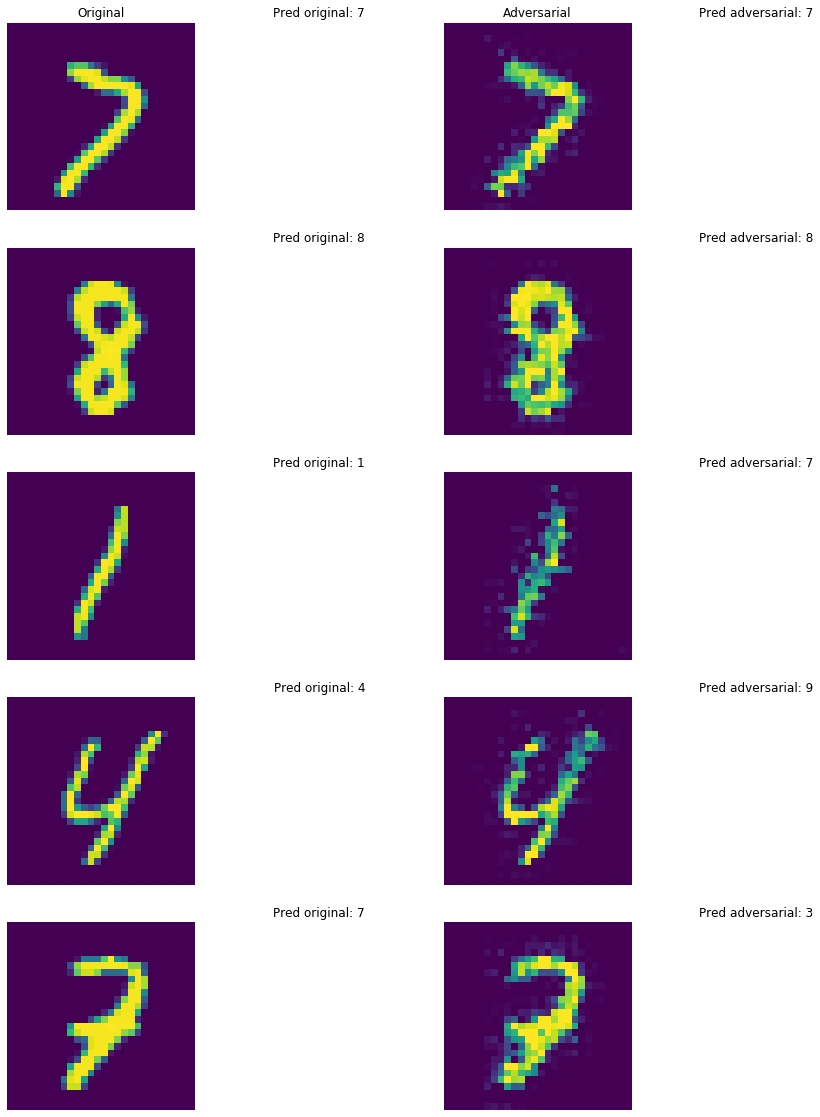

In [28]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (28, 28)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')